In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, logistic
from scipy.optimize import minimize
import os
from IPython.display import display
from scipy.stats import logistic
import torch

In [4]:
# Check if GPU is available
if torch.cuda.is_available():
    print(f"✅ GPU is available! ({torch.cuda.get_device_name(0)})")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("❌ No GPU detected. Running on CPU.")

✅ GPU is available! (NVIDIA GeForce RTX 3050 Laptop GPU)
Total GPU Memory: 4.29 GB


# ImageNet

In [5]:
# Load dataset
DATA_PATH = r"e:/thesis/irtnet/data/Binary Processed/Binary_Transformed_ImageNet.csv"
df = pd.read_csv(DATA_PATH)

In [6]:
# Function to fit a 2PL IRT model using GPU-accelerated optimization
def estimate_2PL_params_gpu(data):
    """
    Estimates item discrimination (a) and difficulty (b) parameters using GPU.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")  # Check if running on GPU

    num_items = data.shape[1]
    params = []

    # Convert data to PyTorch tensor
    data_tensor = torch.tensor(data.values, dtype=torch.float32, device=device)

    # Define log-likelihood function for each item
    def log_likelihood(params, item_responses, theta):
        a, b = params
        prob_correct = torch.sigmoid(a * (theta - b))
        return -torch.sum(item_responses * torch.log(prob_correct + 1e-9) + (1 - item_responses) * torch.log(1 - prob_correct + 1e-9))

    # Fit 2PL for each item
    theta = torch.linspace(-3, 3, data.shape[0], device=device)  # Initial ability estimates
    for i in range(num_items):
        item_responses = data_tensor[:, i]
        
        res = minimize(
            lambda p: log_likelihood(torch.tensor(p, device=device), item_responses, theta).cpu().detach().numpy(),
            [1, 0],  # Initial (a, b)
            method="L-BFGS-B"
        )
        params.append(res.x)

    return np.array(params)

In [7]:
# Function to estimate person abilities (theta) using GPU-accelerated MLE
def estimate_theta_gpu(data, item_params):
    """
    Estimates theta (ability scores) using GPU-accelerated Maximum Likelihood Estimation (MLE).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_people = data.shape[0]
    num_items = data.shape[1]

    # Convert data and parameters to PyTorch tensors
    data_tensor = torch.tensor(data.values, dtype=torch.float32, device=device)
    item_params_tensor = torch.tensor(item_params, dtype=torch.float32, device=device)

    theta_estimates = torch.zeros(num_people, device=device)  # Initialize theta estimates

    # Define log-likelihood function for theta
    def log_likelihood(theta, responses, params):
        likelihood = 0
        for j in range(num_items):
            a, b = params[j]
            prob_correct = torch.sigmoid(a * (theta - b))
            likelihood += responses[j] * torch.log(prob_correct + 1e-9) + (1 - responses[j]) * torch.log(1 - prob_correct + 1e-9)
        return -likelihood

    # Fit theta for each person
    for i in range(num_people):
        responses = data_tensor[i, :]
        res = minimize(
            lambda t: log_likelihood(torch.tensor(t, device=device), responses, item_params_tensor).cpu().detach().numpy(),
            [0],  # Initial theta
            method="L-BFGS-B"
        )
        theta_estimates[i] = res.x[0]

    return theta_estimates.cpu().numpy()

In [8]:
# Function to compute Item Characteristic Curve (ICC)
def compute_icc(item_param, theta_range=(-3, 3), num_points=100):
    """
    Computes the Item Characteristic Curve (ICC) for a given item.
    """
    a, b = item_param
    theta = np.linspace(theta_range[0], theta_range[1], num_points)
    prob_correct = logistic.cdf(a * (theta - b))
    return theta, prob_correct

In [9]:
# Identify item response columns
item_cols = [col for col in df.columns if col.startswith('Answer_')]

# Check if item_cols is empty
if not item_cols:
    raise ValueError("No valid item columns found. Ensure columns start with 'Answer_'.")

# Fit 2PL IRT model and estimate item parameters
item_params_2PL = estimate_2PL_params_gpu(df[item_cols])

# Estimate theta (ability scores) using 2PL Model
df["theta_2PL"] = estimate_theta_gpu(df[item_cols], item_params_2PL)

# Debugging: Check theta values
print("Theta estimates (first 5):", df["theta_2PL"].head())

Using device: cuda
Theta estimates (first 5): 0    -0.864999
1     1.252763
2     0.374693
3    15.445931
4     2.525728
Name: theta_2PL, dtype: float32


In [10]:
# Function to compute empirical item response function
def empirical_irf(data, item_col, ability_col, bins=10):
    """
    Computes empirical Item Response Function (IRF) by binning ability levels.
    """
    data["ability_bin"] = pd.qcut(data[ability_col], q=bins, duplicates='drop')
    irf = data.groupby("ability_bin")[item_col].mean()
    return irf

In [11]:
# Function to check monotonicity with Spearman correlation
def check_monotonicity(data, item_col, ability_col):
    """
    Checks monotonicity by computing Spearman correlation between ability and item response.
    """
    corr, p_value = spearmanr(data[ability_col], data[item_col])
    return corr, p_value

Processing Answer_resnet18...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()


Processing Answer_resnet34...
Processing Answer_resnet50...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

Processing Answer_resnet101...
Processing Answer_resnet152...
Processing Answer_densenet121...
Processing Answer_densenet161...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

Processing Answer_densenet169...
Processing Answer_densenet201...
Processing Answer_efficientnet_b0...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()


Processing Answer_efficientnet_b1...
Processing Answer_efficientnet_b2...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()


Processing Answer_efficientnet_b3...
Processing Answer_efficientnet_b4...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

Processing Answer_vgg11...
Processing Answer_vgg13...
Processing Answer_vgg16...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

Processing Answer_vgg19...
Processing Answer_mobilenet_v2...
Processing Answer_mobilenet_v3_large...
Processing Answer_mobilenet_v3_small...
Processing Answer_alexnet...
Processing Answer_shufflenet_v2_x0_5...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()
C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

Processing Answer_shufflenet_v2_x1_0...
Processing Answer_squeezenet1_0...
Processing Answer_squeezenet1_1...
Processing Answer_inception_v3...


C:\Users\madha\AppData\Local\Temp\ipykernel_23316\3999561538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  irf = data.groupby("ability_bin")[item_col].mean()


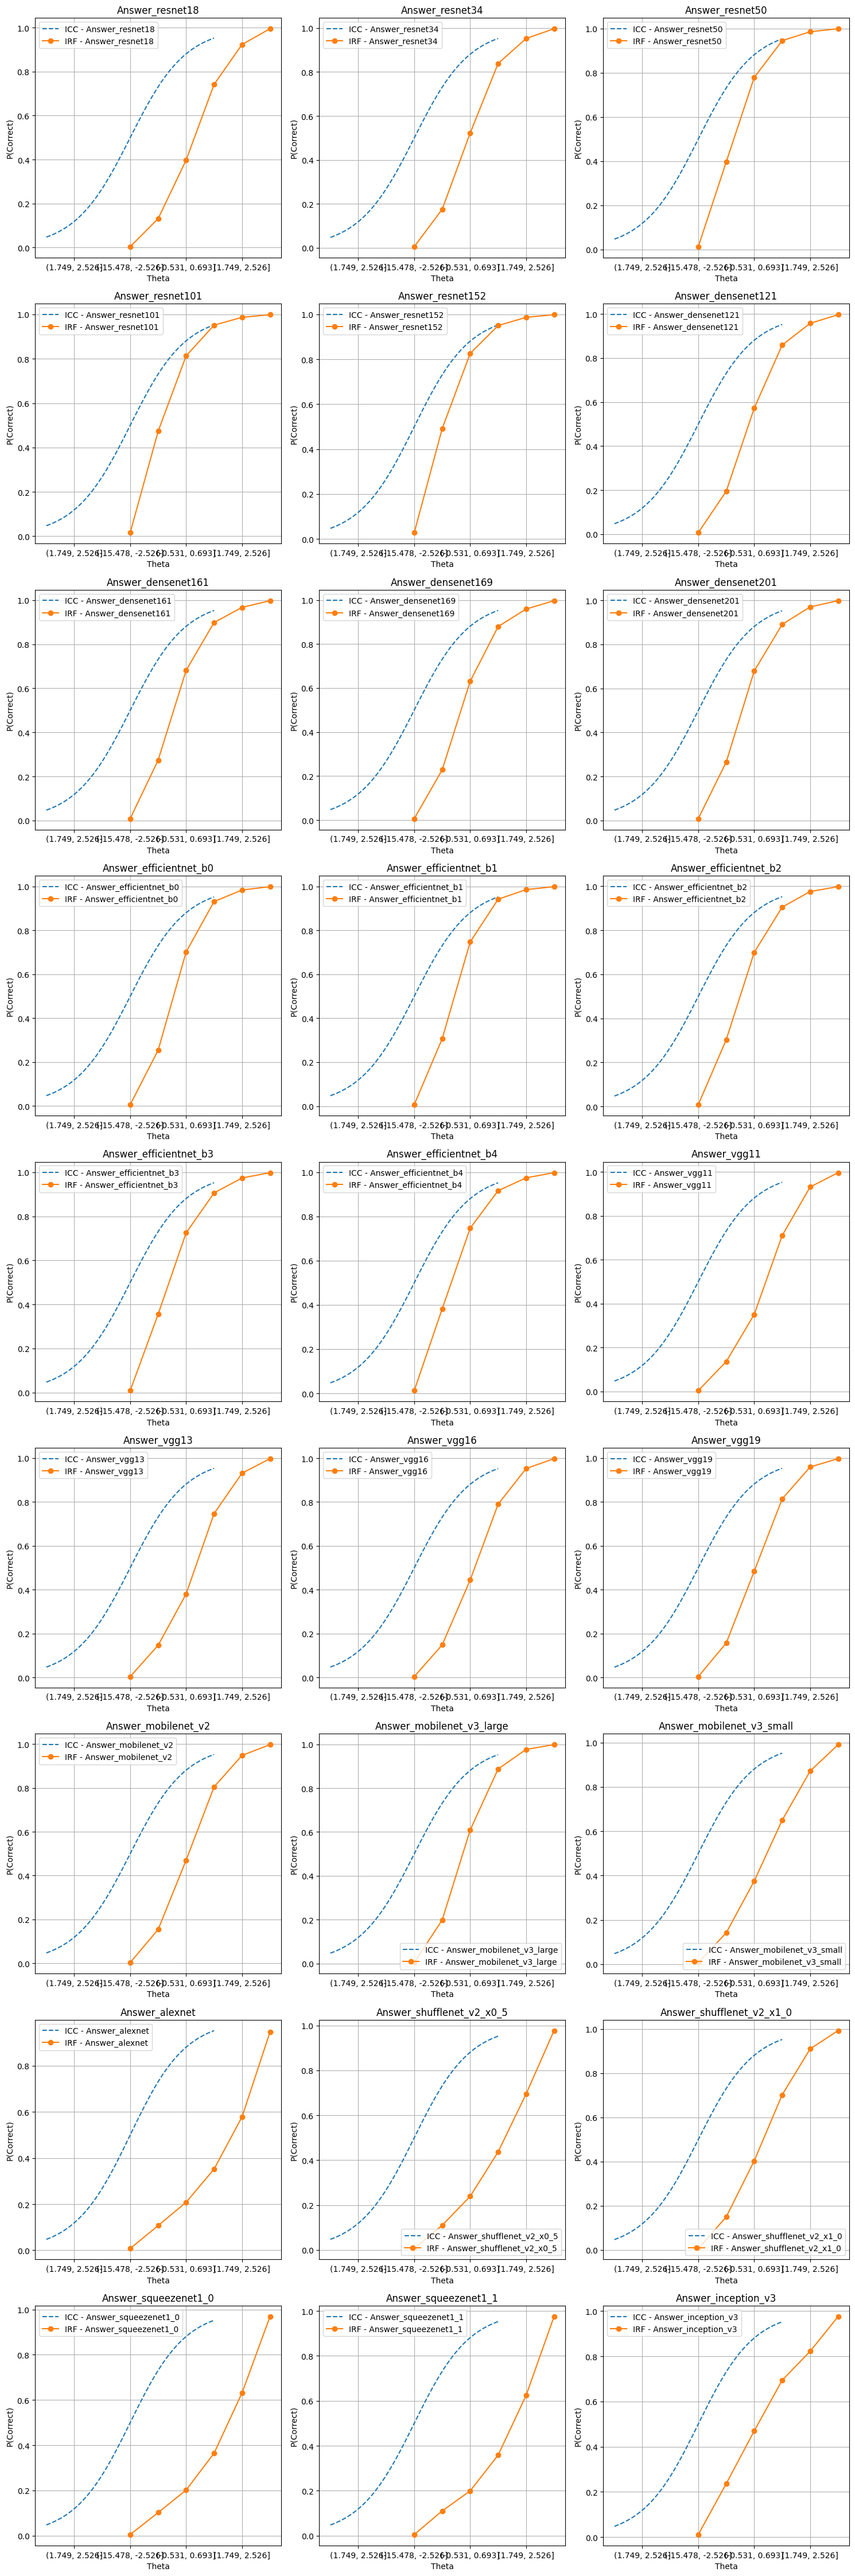

,Dataset,Item,Spearman_rho,p_value
0,ImageNet,Answer_resnet18,0.812127,0.0
1,ImageNet,Answer_resnet34,0.803326,0.0
2,ImageNet,Answer_resnet50,0.770740,0.0
3,ImageNet,Answer_resnet101,0.761377,0.0
4,ImageNet,Answer_resnet152,0.754779,0.0
5,ImageNet,Answer_densenet121,0.799833,0.0
6,ImageNet,Answer_densenet161,0.785485,0.0
7,ImageNet,Answer_densenet169,0.792430,0.0
8,ImageNet,Answer_densenet201,0.787093,0.0
9,ImageNet,Answer_efficientnet_b0,0.792133,0.0


In [12]:
# Run monotonicity check and plot IRFs/ICCs in a grid
num_items = len(item_cols)
num_cols = 3  # Number of columns in the grid
num_rows = int(np.ceil(num_items / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

results = {}
for idx, item_col in enumerate(item_cols):
    print(f"Processing {item_col}...")  # Debugging: Track item processing
    irf = empirical_irf(df, item_col, "theta_2PL")
    corr, p_value = check_monotonicity(df, item_col, "theta_2PL")
    results[item_col] = {"Spearman_rho": corr, "p_value": p_value, "IRF": irf}

    # Compute ICC
    theta, icc = compute_icc(item_params_2PL[idx])

    # Plot both IRF and ICC in the grid
    ax = axes[idx]
    ax.plot(theta, icc, label=f"ICC - {item_col}", linestyle="--")
    irf.plot(ax=ax, marker='o', linestyle='-', label=f"IRF - {item_col}")
    ax.set_title(f"{item_col}")
    ax.set_xlabel("Theta")
    ax.set_ylabel("P(Correct)")
    ax.legend()
    ax.grid()

# Hide unused subplots
for i in range(len(item_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Save results as a summary CSV
summary_data = []
for item, values in results.items():
    summary_data.append(["ImageNet", item, values["Spearman_rho"], values["p_value"]])
summary_df = pd.DataFrame(summary_data, columns=["Dataset", "Item", "Spearman_rho", "p_value"])
#summary_df.to_csv("monotonicity_summary_ImageNet.csv", index=False)

# Display results in Jupyter Notebook
display(summary_df)


In [13]:
def estimate_mirt_params_gpu(data, num_factors=2, learning_rate=0.01, max_iterations=500, tol=1e-4):
    """
    Estimates MIRT parameters for items and individuals using GPU-accelerated Gradient Descent.
    Stops early if the loss stops improving.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")  # Check if running on GPU

    num_people, num_items = data.shape

    # Convert data to PyTorch tensor and move to GPU
    data_tensor = torch.tensor(data.values, dtype=torch.float32, device=device)

    # Initialize item discrimination (a), difficulty (b), and ability (theta)
    a = torch.rand((num_items, num_factors), device=device, requires_grad=True)  # Discrimination
    b = torch.rand((num_items,), device=device, requires_grad=True)  # Difficulty
    theta = torch.rand((num_people, num_factors), device=device, requires_grad=True)  # Ability

    optimizer = torch.optim.Adam([a, b, theta], lr=learning_rate)
    prev_loss = float('inf')
    loss_history = []

    for iteration in range(max_iterations):
        optimizer.zero_grad()  # Reset gradients

        # Compute probability matrix using vectorized operations
        prob_correct = torch.sigmoid(torch.matmul(theta, a.T) - b)  # (N, M) matrix
        log_likelihood = data_tensor * torch.log(prob_correct + 1e-9) + (1 - data_tensor) * torch.log(1 - prob_correct + 1e-9)

        # Compute total loss (negative log-likelihood)
        total_loss = -log_likelihood.sum()
        total_loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        loss_history.append(total_loss.item())

        if iteration % 50 == 0:
            print(f"Iteration {iteration}: Loss = {total_loss.item():.4f}")

        # Early stopping if loss change is small
        if abs(prev_loss - total_loss.item()) < tol:
            print(f"Stopping early at iteration {iteration}: Loss change < {tol}")
            break

        prev_loss = total_loss.item()

    # Convert results back to NumPy (CPU)
    return a.detach().cpu().numpy(), b.detach().cpu().numpy(), theta.detach().cpu().numpy(), loss_history


# # Estimate MIRT parameters
# a_mirt, b_mirt, theta_mirt = estimate_mirt_params(df[item_cols])

# # Debugging: Check MIRT parameters
# print("MIRT Discrimination Parameters (a):", a_mirt)
# print("MIRT Difficulty Parameters (b):", b_mirt)
# print("MIRT Ability Estimates (Theta):", theta_mirt[:5])


In [14]:
a_mirt, b_mirt, theta_mirt, loss_history = estimate_mirt_params_gpu(df[item_cols])


Using device: cuda
Iteration 0: Loss = 953654.5000
Iteration 50: Loss = 554790.8750
Iteration 100: Loss = 339923.6875
Iteration 150: Loss = 288224.7500
Iteration 200: Loss = 271356.8750
Iteration 250: Loss = 262944.6250
Iteration 300: Loss = 257673.3125
Iteration 350: Loss = 253928.3750
Iteration 400: Loss = 251038.6562
Iteration 450: Loss = 248643.1250


In [15]:
# Visualization for MIRT
# 1. Scatter Plot of Discrimination Parameters
def plot_discrimination(a_mirt):
    plt.figure(figsize=(8, 6))
    for i in range(a_mirt.shape[1]):
        plt.scatter(range(a_mirt.shape[0]), a_mirt[:, i], label=f"Factor {i+1}")
    plt.title("Discrimination Parameters by Factor")
    plt.xlabel("Item Index")
    plt.ylabel("Discrimination Parameter (a)")
    plt.legend()
    plt.grid()
    plt.show()

# 2. Theta Distributions for Each Factor
def plot_theta_distributions(theta_mirt):
    num_factors = theta_mirt.shape[1]
    plt.figure(figsize=(10, 6))
    for i in range(num_factors):
        sns.kdeplot(theta_mirt[:, i], label=f"Factor {i+1}", fill=True)
    plt.title("Theta Distributions by Factor")
    plt.xlabel("Theta")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

# 3. Multidimensional ICCs
def plot_mirt_iccs(a_mirt, b_mirt, item_cols, theta_range=(-3, 3), num_points=100):
    num_items = len(b_mirt)
    num_cols = 3  # Number of columns in the grid
    num_rows = int(np.ceil(num_items / num_cols))
    theta1, theta2 = np.meshgrid(
        np.linspace(theta_range[0], theta_range[1], num_points),
        np.linspace(theta_range[0], theta_range[1], num_points)
    )
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i in range(num_items):
        prob_correct = logistic.cdf(a_mirt[i, 0] * theta1 + a_mirt[i, 1] * theta2 - b_mirt[i])
        ax = axes[i]
        contour = ax.contourf(theta1, theta2, prob_correct, levels=20, cmap="viridis")
        plt.colorbar(contour, ax=ax)
        ax.set_title(item_cols[i])
        ax.set_xlabel("Theta 1")
        ax.set_ylabel("Theta 2")
        ax.grid()

    # Hide unused subplots
    for i in range(num_items, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

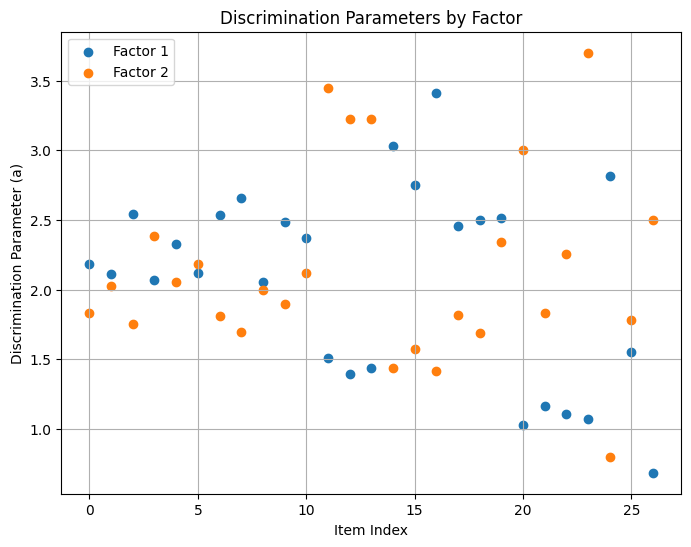

In [16]:
plot_discrimination(a_mirt)


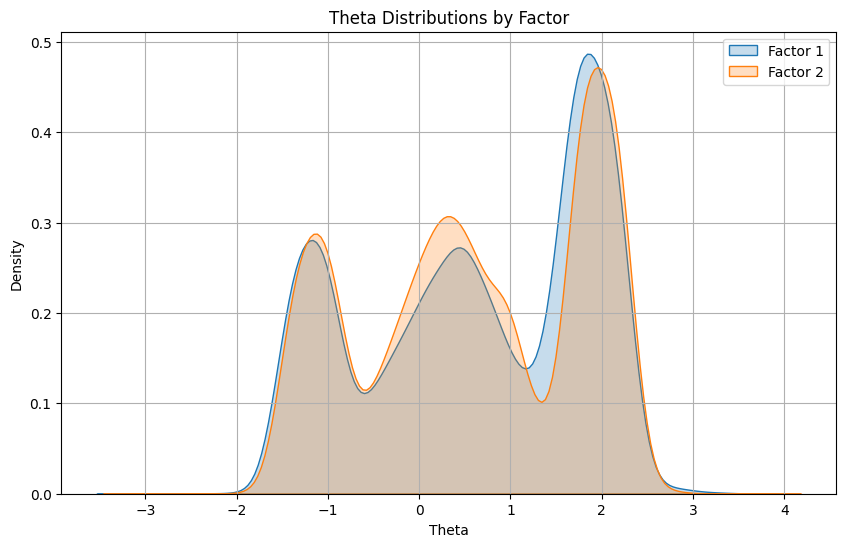

In [17]:
plot_theta_distributions(theta_mirt)


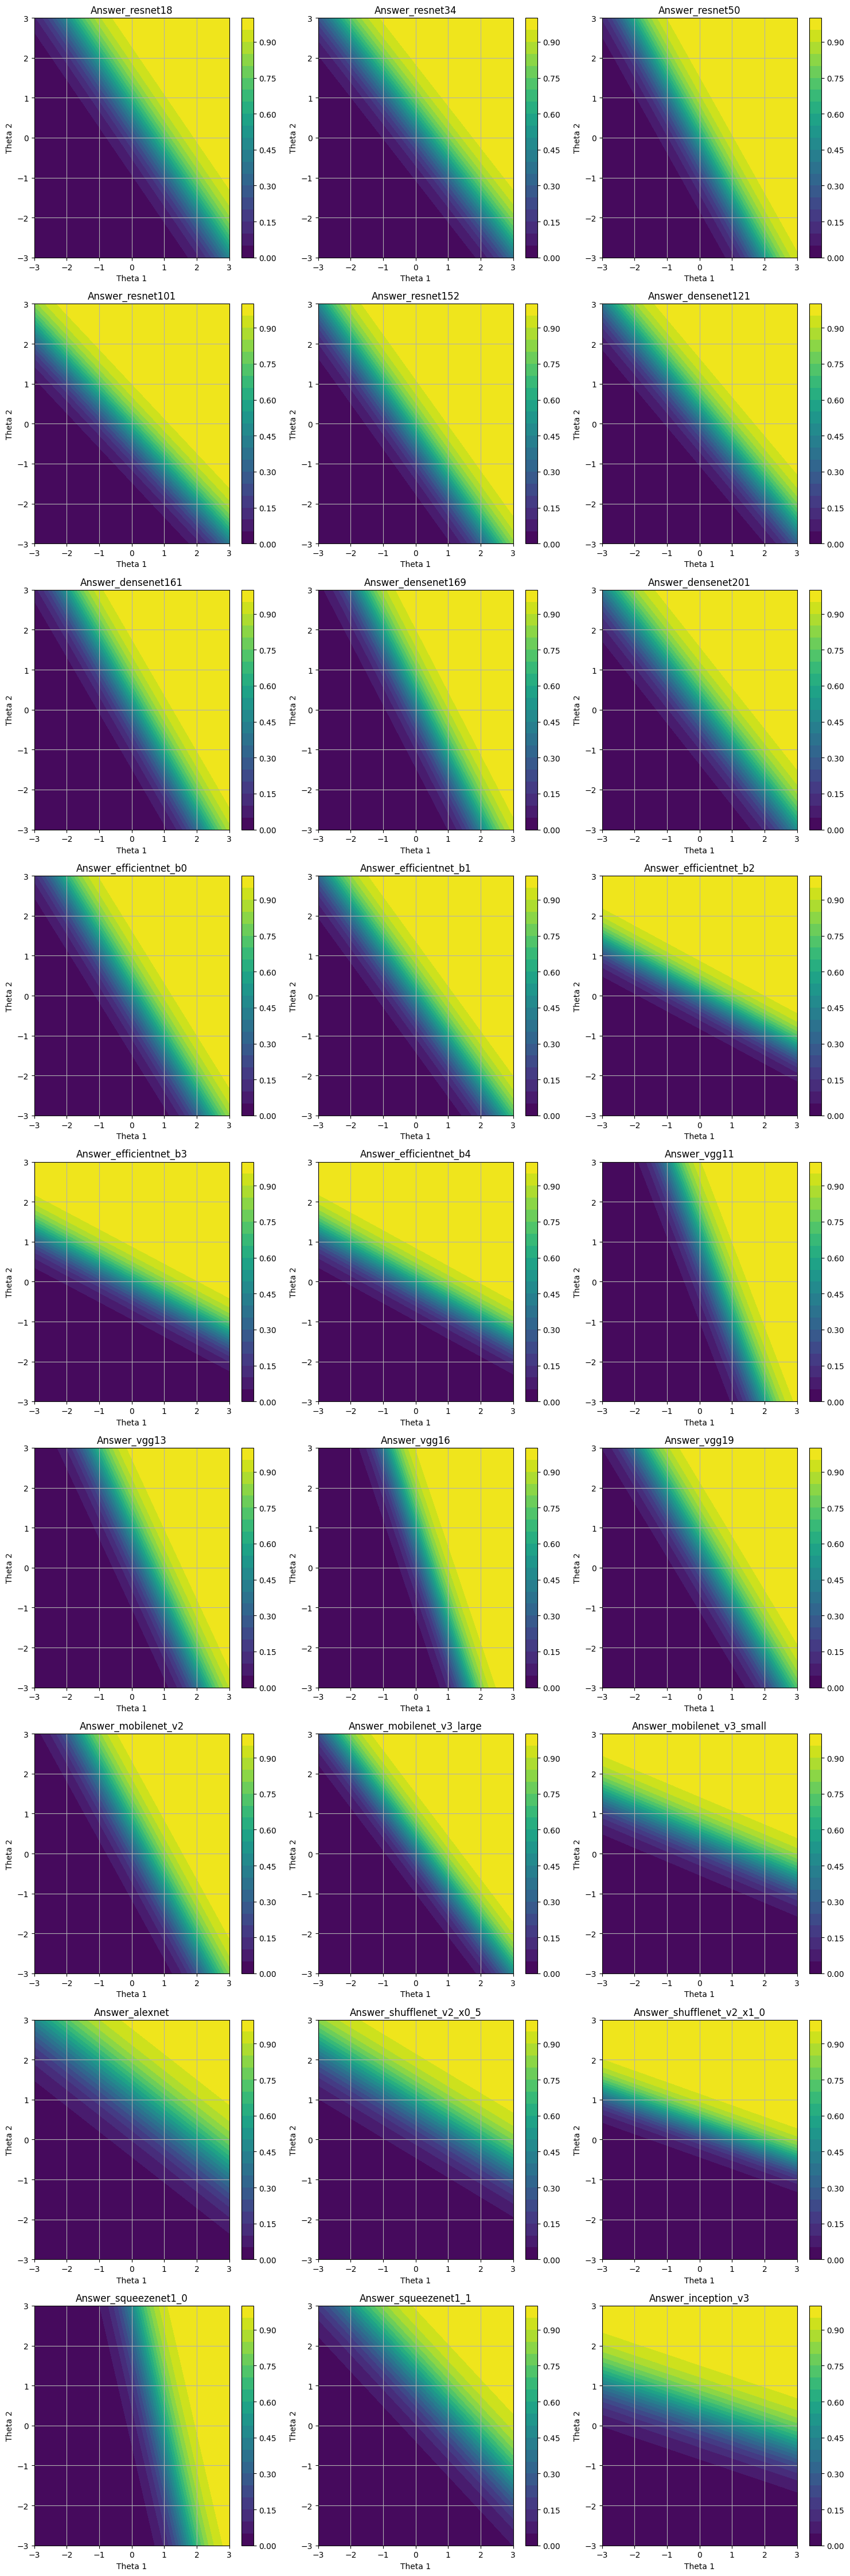

In [18]:
plot_mirt_iccs(a_mirt, b_mirt, item_cols)


# ImageNet V2

In [1]:
# Load dataset
DATA_PATH = r"e:/thesis/irtnet/data/Binary Processed/Binary_Transformed_ImageNet-V2.csv"
df = pd.read_csv(DATA_PATH)

NameError: name 'pd' is not defined